In [114]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
#from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

### Part 1: Extract license plate from sample image

In [115]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [116]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


1/1 [==============================] - 2s 2s/step


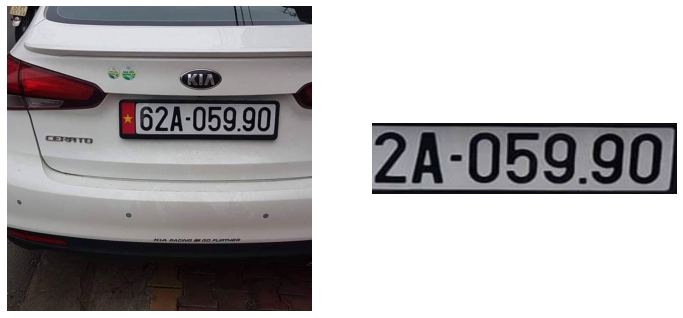

In [117]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , img, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, img, cor

test_image_path = "vietnam_car_rectangle_plate.jpg"
vehicle, img,cor = get_plate(os.path.join("/Users/apple/Desktop/Project/Team 6/Plate_examples" ,test_image_path))


fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(img[0])
plt.savefig("cropping.png", dpi=300)

## Part 2: Segementing license characters

In [122]:
def anpr(img):
    if (len(img)): 
        #plate_image = cv2.convertScaleAbs(img, alpha=(255.0))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)
        binary = cv2.threshold(blur, 180, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    # Create sort_contours() function to grab the contour of each digit from left to right
    def sort_contours(cnts,reverse = False):
        i = 0
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                            key=lambda b: b[1][i], reverse=reverse))
        return cnts

    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    test_roi = img.copy()
    crop_characters = []
    digit_w, digit_h = 180, 180

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1<=ratio<=5: # Only select contour with defined ratio
            if h/img.shape[0]>=0.3:
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)

    grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

    # loading model 2.0
    model = keras.models.load_model('Model 3.0.h5')
    out = []
    for i in range(len(crop_characters)):
        x = crop_characters[i]
        x = np.reshape(x, (180, 180, 1))
        x = np.concatenate([x, x, x], axis=2)
        x = np.expand_dims(x, axis=0)
        x = np.concatenate([x for _ in range(32)], axis=0)
        p1 = model.predict(x)
        

        c=np.argmax(p1)
        out.append(c)

    classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    txt = ""
    for i in (out):
        if(i<36):
            txt = txt+classes[i]
        else:
            txt = txt+"-"
    return txt



image = cv2.imread('image.png')  
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite('opncv_sample.png', img) 
anpr(img)

1/1 [==============================] - 0s 106ms/step


'11-9-'